# single-cell spot

In [1]:
import sys
import os
import random
import scanpy as sc
import squidpy as sq
import numpy as np
import pandas as pd
from anndata import AnnData
import pathlib
import matplotlib.pyplot as plt
import matplotlib as mpl
import skimage
import json
import seaborn as sns
#from map_utils import *
#from plot_utils import *
import copy
from orderedset import OrderedSet
import DeepTalk_ST as dt
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [ ]:
# Skip this cells if data are already downloaded
!wget https://storage.googleapis.com/tommaso-brain-data/tangram_demo/mop_sn_tutorial.h5ad.gz -O data/mop_sn_tutorial.h5ad.gz
!wget https://storage.googleapis.com/tommaso-brain-data/tangram_demo/slideseq_MOp_1217.h5ad.gz -O data/slideseq_MOp_1217.h5ad.gz
!wget https://storage.googleapis.com/tommaso-brain-data/tangram_demo/MOp_markers.csv -O data/MOp_markers.csv
!gunzip -f data/mop_sn_tutorial.h5ad.gz
!gunzip -f data/slideseq_MOp_1217.h5ad.gz

In [2]:
os.chdir("./single-cell")

In [3]:
random.seed(1000)
ad_st = sc.read_csv('./st_flie.txt', delimiter='\t', first_column_names=True)
ad_st

AnnData object with n_obs × n_vars = 2399 × 268

In [4]:
ad_st_raw = copy.deepcopy(ad_st)
#ad_st_raw = ad_st
sc.pp.normalize_total(ad_st)
#ad_st_raw1 = copy.deepcopy(ad_st)
#sc.pp.normalize_per_cell(ad_st, counts_per_cell_after=1e4)
sc.pp.log1p(ad_st)

In [5]:
ad_st

AnnData object with n_obs × n_vars = 2399 × 268
    uns: 'log1p'

In [6]:
st_spatial = np.loadtxt("./st_location.txt",dtype=str, delimiter=' ')
st_spatial = st_spatial.astype(np.float64)

In [7]:
ad_st.obs['x'] = st_spatial[:,0]
ad_st.obs['y'] = st_spatial[:,1]
ad_st.obsm["spatial"]=st_spatial
ad_st_raw.obsm["spatial"]=st_spatial


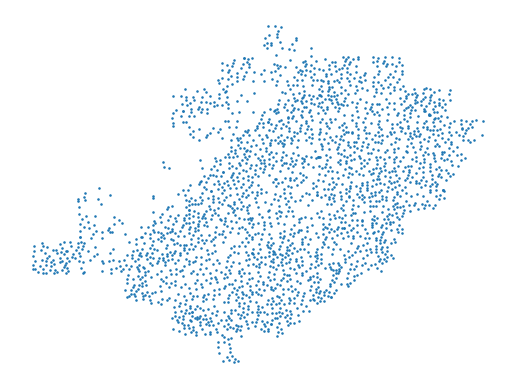

In [8]:
xs = ad_st.obs.x.values
ys = ad_st.obs.y.values
plt.axis('off')
plt.scatter(xs, ys, s=.7);
plt.gca().invert_yaxis()
plt.savefig('./fig/Visp_Mer.pdf',bbox_inches='tight',dpi=300)

In [9]:
path = os.path.join('./tangram_demo_visp_sn_tpm_small_0430.h5ad')
ad_sc = sc.read_h5ad(path)
ad_sc

AnnData object with n_obs × n_vars = 11759 × 40056
    obs: 'consensus_cluster', 'reference_cluster', 'reference_color', 'broad_class', 'subclass', 'merged_cluster_smFISH', 'merged_cluster_ISS', 'total_reads', 'cpm_scaling_factor', 'n_genes'
    var: 'length', 'maxMeanFpkm', 'in_MERFISH', 'gene_id', 'chromosome', 'gene_entrez_id', 'gene_name', 'n_cells'

In [10]:
ad_sc_raw0 = copy.deepcopy(ad_sc)
sc.pp.normalize_total(ad_sc)
#sc.pp.normalize_per_cell(ad_sc, counts_per_cell_after=1e4)
ad_sc_raw1 = copy.deepcopy(ad_sc)
sc.pp.log1p(ad_sc)
ad_sc_raw = copy.deepcopy(ad_sc)
sc.pp.highly_variable_genes(ad_sc, min_mean=0.0125, max_mean=4, min_disp=0.25)
sc.pp.scale(ad_sc, max_value=10)
ad_sc_raw2 = copy.deepcopy(ad_sc)
sc.pp.pca(ad_sc)
sc.pp.neighbors(ad_sc)
sc.tl.umap(ad_sc)
ad_sc

AnnData object with n_obs × n_vars = 11759 × 40056
    obs: 'consensus_cluster', 'reference_cluster', 'reference_color', 'broad_class', 'subclass', 'merged_cluster_smFISH', 'merged_cluster_ISS', 'total_reads', 'cpm_scaling_factor', 'n_genes'
    var: 'length', 'maxMeanFpkm', 'in_MERFISH', 'gene_id', 'chromosome', 'gene_entrez_id', 'gene_name', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [11]:
ad_sc_raw.obsm['X_umap']=ad_sc.obsm['X_umap']


In [12]:
df_genes = pd.read_csv('./MERFISH_genes.csv',header=None)
markers = np.reshape(df_genes.values[:,-1], (-1, ))
markers = list(markers)
len(markers)

254

In [13]:
dt.pp_adatas(ad_sc_raw, ad_st, genes=markers)

INFO:root:253 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:257 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.


In [14]:
ad_map = dt.map_cells_to_space(
    adata_sc=ad_sc_raw,
    adata_sp=ad_st,
    learning_rate=0.0001,
    num_epochs=3000,
    device='cuda:1',
)

Start training
Epoch 100, Loss: -0.558,Score0: 0.558,Time: 0.089
Epoch 200, Loss: -0.610,Score0: 0.610,Time: 0.090
Epoch 300, Loss: -0.639,Score0: 0.639,Time: 0.090
Epoch 400, Loss: -0.658,Score0: 0.658,Time: 0.089
Epoch 500, Loss: -0.671,Score0: 0.671,Time: 0.091
Epoch 600, Loss: -0.682,Score0: 0.682,Time: 0.087
Epoch 700, Loss: -0.689,Score0: 0.689,Time: 0.088
Epoch 800, Loss: -0.696,Score0: 0.696,Time: 0.089
Epoch 900, Loss: -0.701,Score0: 0.701,Time: 0.090
Epoch 1000, Loss: -0.706,Score0: 0.706,Time: 0.089
Epoch 1100, Loss: -0.710,Score0: 0.710,Time: 0.090
Epoch 1200, Loss: -0.714,Score0: 0.714,Time: 0.091
Epoch 1300, Loss: -0.718,Score0: 0.718,Time: 0.090
Epoch 1400, Loss: -0.721,Score0: 0.721,Time: 0.091
Epoch 1500, Loss: -0.724,Score0: 0.724,Time: 0.088
Epoch 1600, Loss: -0.726,Score0: 0.726,Time: 0.090
Epoch 1700, Loss: -0.729,Score0: 0.729,Time: 0.070
Epoch 1800, Loss: -0.731,Score0: 0.731,Time: 0.091
Epoch 1900, Loss: -0.733,Score0: 0.733,Time: 0.089
Epoch 2000, Loss: -0.735,

INFO:root:spatial prediction dataframe is saved in `obsm` `tangram_ct_pred` of the spatial AnnData.


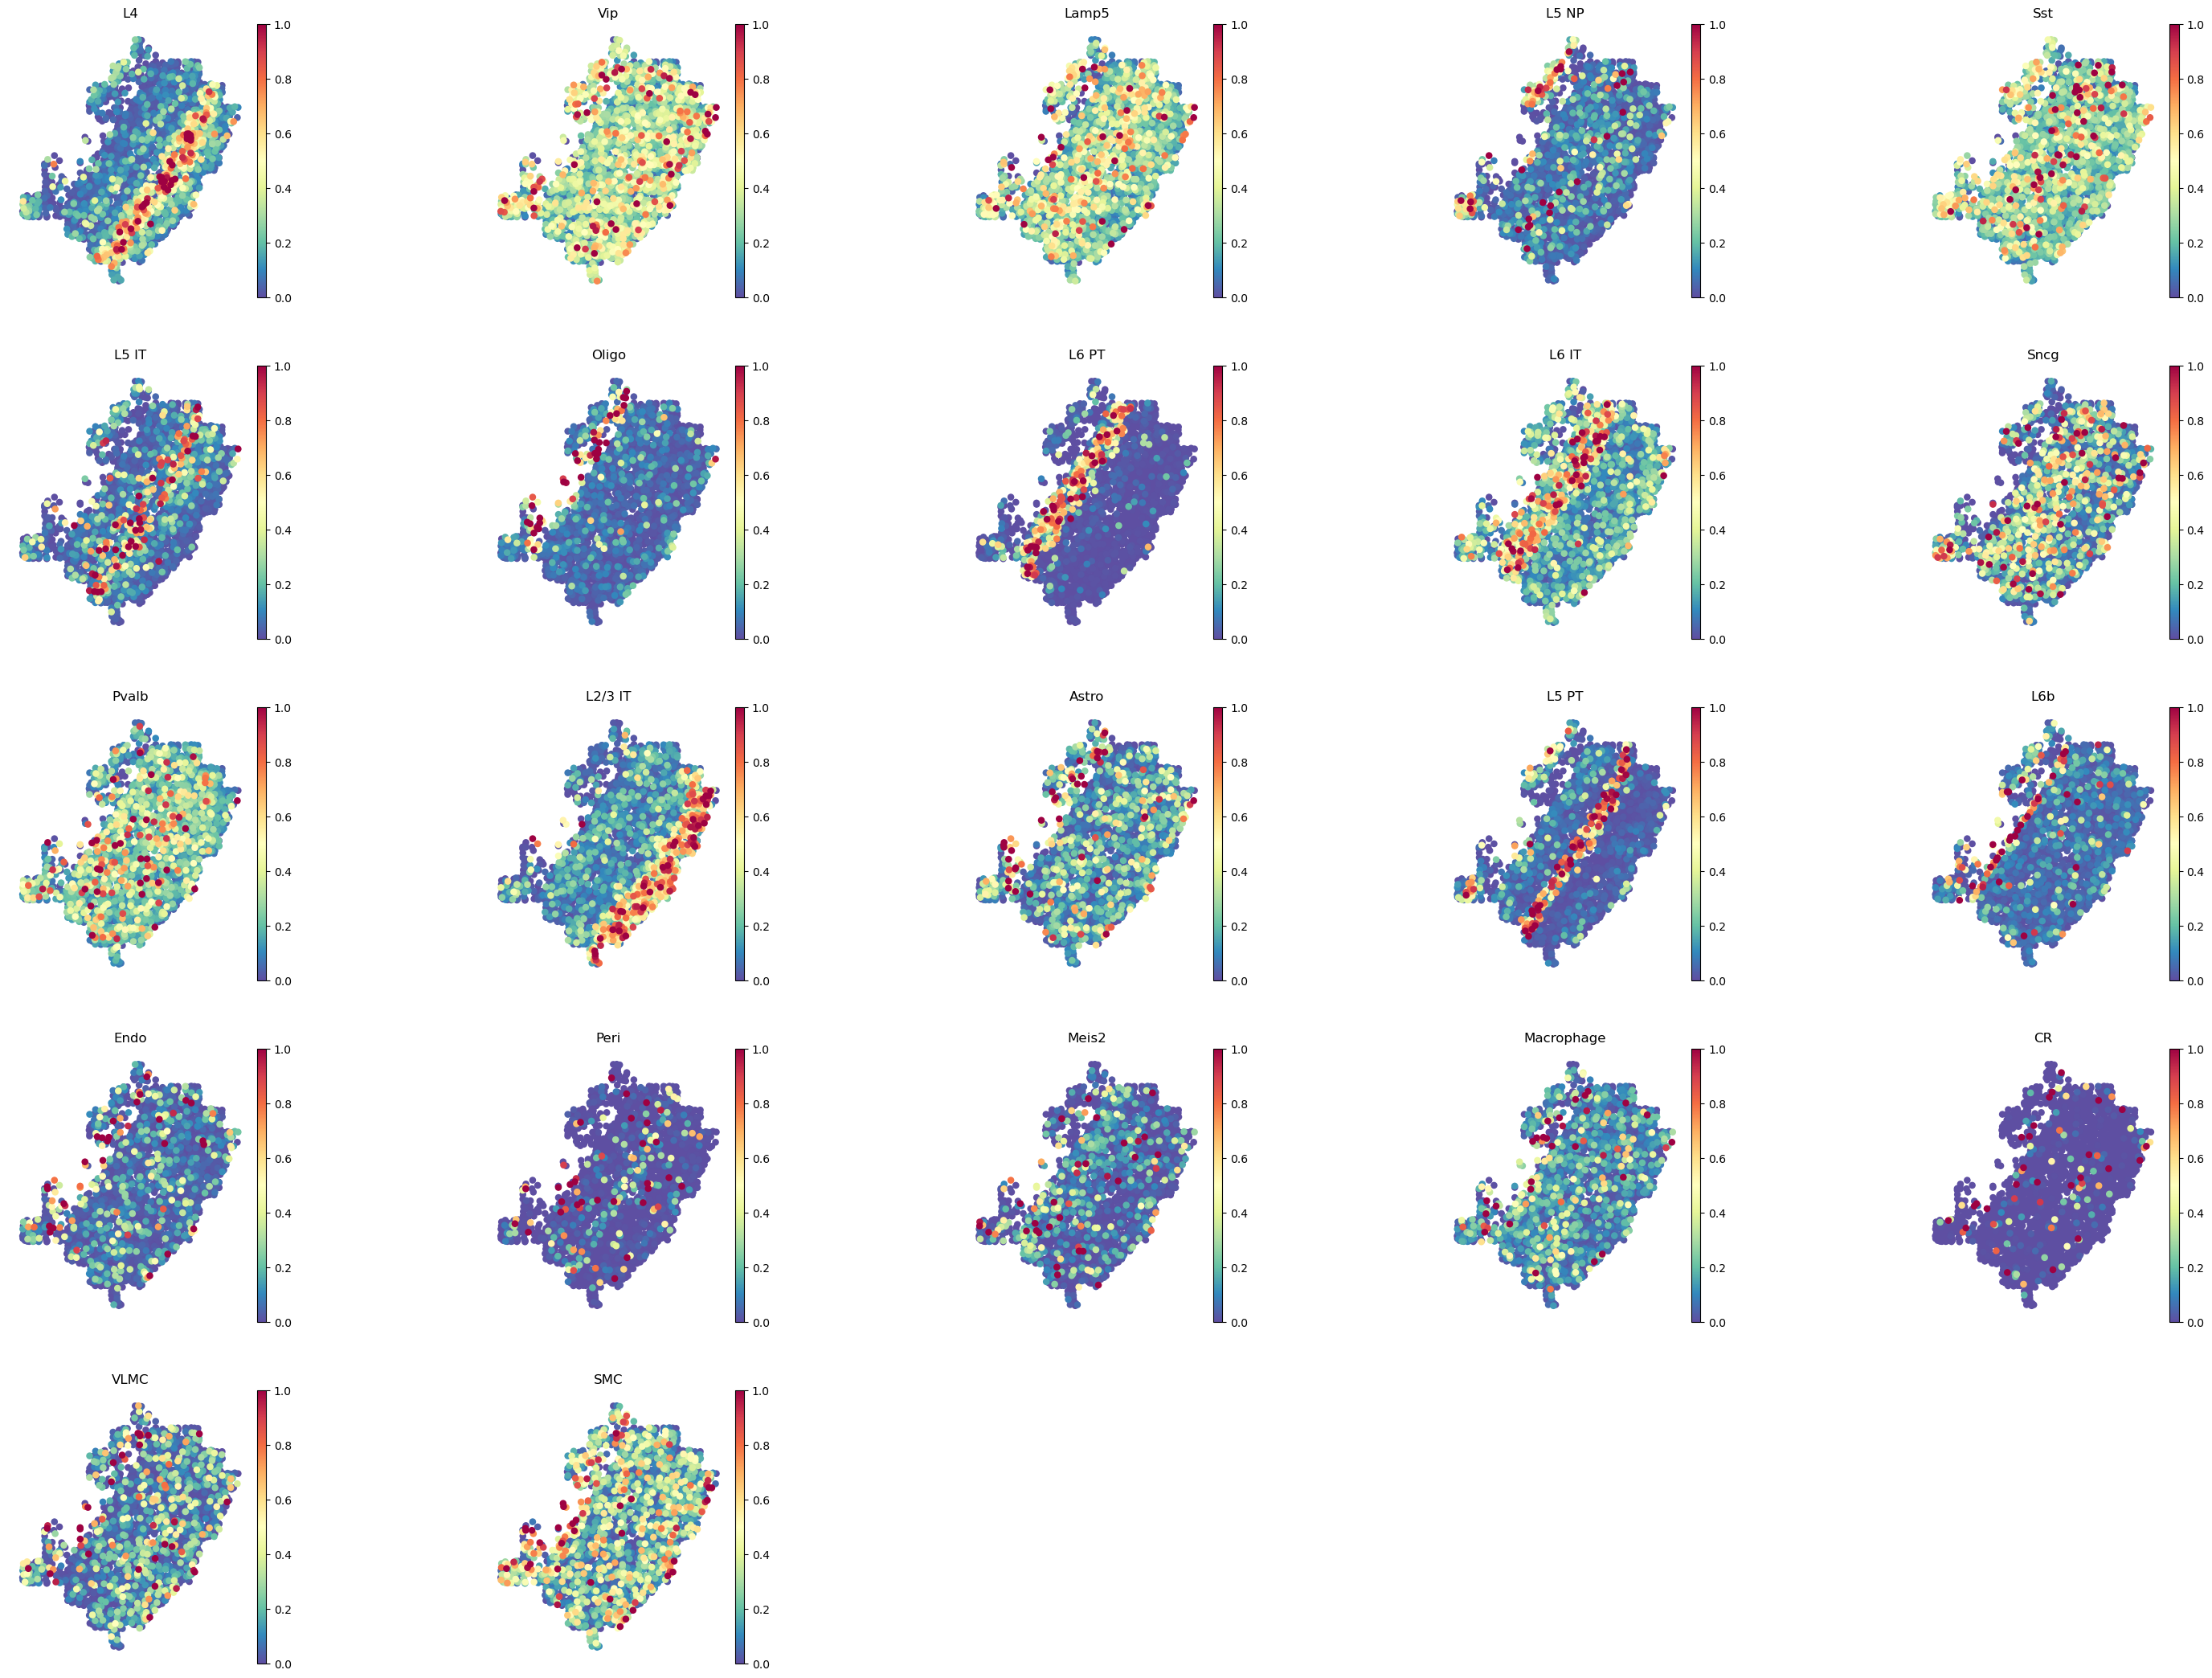

In [17]:
dt.project_cell_annotations(ad_map, ad_st, annotation="subclass")
annotation_list = list(pd.unique(ad_sc_raw.obs['subclass']))
dt.plot_cell_annotation_sc1(ad_st, annotation_list,spot_size=65, ncols=5,cmap='Spectral_r', scale_factor=0.1,perc=0.01)


In [18]:
ad_st.obs.to_csv('./st_obs.csv')

lrpairs = pd.read_csv('../lrpairs_new.csv')
lr_all_human = lrpairs.iloc[0:4715,:].ligand.unique().tolist()+lrpairs.iloc[0:4715,:].receptor.unique().tolist()
lr_all_human_new = list(set(lr_all_human))

lr_all_mouse = lrpairs.iloc[4715:,:].ligand.unique().tolist()+lrpairs.iloc[0:4715,:].receptor.unique().tolist()
lr_all_mouse_new = list(set(lr_all_mouse))

In [19]:
tf = pd.read_csv('../df_pathways.csv')
tf_human = tf.iloc[0:370593,:].src.unique().tolist()+tf.iloc[0:370593,:].dest.unique().tolist()
tf_human_new = list(set(tf_human))

tf_mouse = tf.iloc[370593:,:].src.unique().tolist()+tf.iloc[0:370593,:].dest.unique().tolist()
tf_mouse_new = list(set(tf_mouse))

In [20]:
gene_all_mouse=list(set(tf_mouse_new + lr_all_mouse_new))
gene_all_human=list(set(tf_human_new + lr_all_human_new))

In [21]:
ad_ge = dt.project_genes(adata_map=ad_map, adata_sc=ad_sc_raw)
ad_ge

AnnData object with n_obs × n_vars = 2399 × 40056
    obs: 'x', 'y', 'uniform_density', 'rna_count_based_density'
    var: 'length', 'maxMeanFpkm', 'in_MERFISH', 'gene_id', 'chromosome', 'gene_entrez_id', 'gene_name', 'n_cells', 'sparsity', 'is_training'
    uns: 'log1p', 'training_genes', 'overlap_genes'

In [22]:
#sc.pp.calculate_qc_metrics(ad_ge, inplace=True)
sc.pp.filter_cells(ad_ge, min_genes=200)
sc.pp.filter_genes(ad_ge, min_cells=3)
#sc.pp.filter_genes(ad_ge, min_counts=1)
sc.pp.filter_genes_dispersion(ad_ge, flavor='cell_ranger', log=False)
ad_ge = ad_ge[:, ad_ge.X.mean(axis=0) >= 0.1]

ad_ge


View of AnnData object with n_obs × n_vars = 2399 × 2037
    obs: 'x', 'y', 'uniform_density', 'rna_count_based_density', 'n_genes'
    var: 'length', 'maxMeanFpkm', 'in_MERFISH', 'gene_id', 'chromosome', 'gene_entrez_id', 'gene_name', 'n_cells', 'sparsity', 'is_training', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'training_genes', 'overlap_genes'

In [23]:
index1 = [word.capitalize() for word in ad_ge.var.index]
c_list = [f'C{i}' for i in range(1, ad_ge.X.shape[0]+1)]
df = pd.DataFrame(ad_ge.X.T,index=index1,columns=c_list)
df = df[df.index.isin(gene_all_mouse)]
df.to_csv('./ad_st_new.csv',float_format='%.2f')
df

,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,...,C2390,C2391,C2392,C2393,C2394,C2395,C2396,C2397,C2398,C2399
Abhd6,0.132941,0.229638,0.127653,0.129377,0.274477,0.204656,0.203259,0.116937,0.240205,0.224180,...,0.363346,0.442540,0.306507,0.356412,0.363305,0.246333,0.611406,0.283361,0.677126,0.622826
Abr,0.070967,0.132350,0.112808,0.076915,0.166743,0.105062,0.143406,0.072732,0.139510,0.170804,...,0.212796,0.287941,0.165964,0.247895,0.178503,0.119304,0.292379,0.179071,0.367566,0.177076
Acaa1a,0.133059,0.150090,0.116519,0.093787,0.191459,0.155644,0.131840,0.108357,0.202626,0.324558,...,0.211730,0.390343,0.207503,0.315123,0.207544,0.138932,0.387092,0.197611,0.618891,0.393257
Acat1,0.216425,0.327695,0.200201,0.220066,0.435481,0.360953,0.286874,0.226593,0.309433,0.460767,...,0.397984,0.654880,0.362205,0.489531,0.414077,0.249840,0.674737,0.360611,0.796756,0.483748
Acot13,0.933478,1.264550,1.083845,0.833452,1.690040,1.436663,1.035841,0.911673,1.310303,2.069561,...,1.711977,2.432605,1.550088,2.035476,1.733071,1.015846,1.794939,1.555331,3.743611,2.752973
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Ywhae,1.235163,1.821065,1.333695,1.210964,2.340430,1.833374,1.478537,1.359512,1.882809,2.303168,...,2.620320,3.923084,2.270128,2.706430,2.710321,1.673608,3.322134,2.230692,4.398202,3.753609
Ywhag,0.219477,0.337686,0.251645,0.226202,0.459681,0.339012,0.254545,0.262582,0.330142,0.497228,...,0.472531,0.637635,0.391379,0.444646,0.484946,0.287345,0.651521,0.408372,0.799019,0.690529
Ywhah,1.447506,2.880456,1.599392,1.705841,3.655992,2.809722,2.035162,2.128654,2.557725,3.025320,...,3.926919,5.049173,3.318218,4.002432,3.965871,2.790858,4.113011,2.866527,4.736515,5.035252
Ywhaq,0.504944,0.725100,0.607483,0.482927,1.086505,0.731646,0.567633,0.535860,0.750349,1.093444,...,1.048697,1.683928,0.882710,1.104440,1.080900,0.664330,1.511970,0.883655,2.206839,1.415086


In [24]:
#Rscript process.R  #生成
os.chdir("./single-cell")

import subprocess
r_script_file = './process.R'

# 运行R脚本
process = subprocess.Popen(['Rscript', r_script_file], stdout=subprocess.PIPE, stderr=subprocess.PIPE, universal_newlines=True)
process.communicate()


('Checking input data \nBegin to filter lrpairs and pathways \n***Done*** \nNote: there are 22 cell types and 462 pair-wise cell pairs \nBegin to find LR pairs \nBegin to write LR pairs \n',
 'There were 50 or more warnings (use warnings() to see the first 50)\n')

In [38]:
import shutil

df = pd.read_csv('./ad_st_new.csv',index_col=0)

lrpairs = pd.read_csv('./lrpairs.csv')
#select L-R pairs

lrpairs_ligand = lrpairs["ligand"]
lrpairs_receptor = lrpairs["receptor"]
#len(lrpairs_ligand)
for ii in range(len(lrpairs)):
    #print(lrpairs_ligand[ii])

    Cellpairall = pd.read_csv('./cell_pair_all.csv')
    ligand = Cellpairall["ligand"]
    receptor = Cellpairall["receptor"]
    Sender = Cellpairall["cell_sender"]
    Receiver = Cellpairall["cell_receiver"]
    CCIlabel = Cellpairall["label"]
    cell_pair_label = []
    
    for i in range(len(Sender)):
        if ligand[i]==lrpairs_ligand[ii] and receptor[i]==lrpairs_receptor[ii]:
            if df.loc[lrpairs_ligand[ii],str(Sender[i])]>0.05 and df.loc[lrpairs_receptor[ii],str(Receiver[i])]>0.05:
                score = np.sqrt(df.loc[lrpairs_ligand[ii],str(Sender[i])]*df.loc[lrpairs_receptor[ii],str(Receiver[i])])
                #print(score)
                cell_pair_label.append([Sender[i],Receiver[i],str(score),str(CCIlabel[i])])
            else:
                score = np.sqrt(df.loc[lrpairs_ligand[ii],str(Sender[i])]*df.loc[lrpairs_receptor[ii],str(Receiver[i])])
                cell_pair_label.append([Sender[i],Receiver[i],str(score),'0'])
    cell_pair = []
    for i in range(len(Sender)):
        if df.loc[lrpairs_ligand[ii],str(Sender[i])]>0 and df.loc[lrpairs_receptor[ii],str(Receiver[i])]>0:
            cell_pair.append([Sender[i],Receiver[i]])
    cell_pair = np.array(cell_pair)
    new_cell_pair = np.unique(cell_pair, axis=0).tolist()
    print(np.sum(np.array(cell_pair_label)[:,-1].astype(np.int32)))
    print(len(new_cell_pair))
    print(np.sum(np.array(cell_pair_label)[:,-1].astype(np.int32))/len(new_cell_pair))
    
    if (len(cell_pair_label))>0:
        print(lrpairs_ligand[ii]+'_'+lrpairs_receptor[ii])
        lrdir = "./data/"+lrpairs_ligand[ii]+'_'+lrpairs_receptor[ii]
        isExists = os.path.exists(lrdir)
        if isExists:
            shutil.rmtree(lrdir)
            os.makedirs(lrdir)
        if not isExists:
            os.makedirs(lrdir)
        cell_pair_label = np.array(cell_pair_label)
        cell_pair_index = cell_pair_label[:,0:2].tolist()
        cell_pair_new = []
        for i in range(len(new_cell_pair)):
            if new_cell_pair[i] in cell_pair_index:
                cell_pair_new.append(['to'] + new_cell_pair[i] + [cell_pair_label[cell_pair_index.index(new_cell_pair[i]),-2]]
                                                                  + [cell_pair_label[cell_pair_index.index(new_cell_pair[i]),-1]])
            else:
                cell_pair_new.append(['to'] + new_cell_pair[i] + [0] + [0])
        CCIlist = np.array(cell_pair_new)
        CCIlist[:, 1] = np.char.replace(CCIlist[:, 1], 'C', '') 
        CCIlist[:, 2] = np.char.replace(CCIlist[:, 2], 'C', '')
        CCIlist[:, 1] = CCIlist[:, 1].astype(np.int)-1
        CCIlist[:, 2] = CCIlist[:, 2].astype(np.int)-1
        
        CCIlist_label = CCIlist[:,-1]
        CCIlist_source = CCIlist[:,1]
        CCIlist_target = CCIlist[:,2]
        #print(CCIlist_source)
        node_list_all = []
        node_list = []
        for i in range(len(CCIlist_label)):
            node_list_all.append(CCIlist_source[i])
            node_list_all.append(CCIlist_target[i])    
            if CCIlist_label[i] == '1':
                node_list.append(CCIlist_source[i])
                node_list.append(CCIlist_target[i])
        print(len(set(node_list_all)))
        print(len(set(node_list)))
        node_no = set(node_list_all) - set(node_list)
        #print(node_no)
        no_index = []
        for i in range(len(CCIlist_label)):
            if CCIlist_source[i] in node_no or CCIlist_target[i] in node_no:
                if CCIlist_label[i] == '0':
                    no_index.append(i)
        #print(no_index)
        CCIlist_score= np.delete(CCIlist, no_index, axis=0)
        print(CCIlist_score.shape)
        
        np.savetxt(lrdir+'/CCIlistscore.txt', CCIlist_score, fmt='%s', delimiter= ' ')
        columns = [0, 1, 2, 4]
        CCIlist_new = CCIlist_score[:,columns]
        np.savetxt(lrdir+'/CCIlist.txt', CCIlist_new, fmt='%s', delimiter= ' ')

        
        random.seed(2022)
        np.random.shuffle(CCIlist_new)

        data_size = len(CCIlist_new)

        data_train = []
        data_validate = []
        data_test = []
        for ii in range(data_size):
            if ii < round(data_size * 0.7):
                data_train.append(CCIlist_new[ii])
            elif ii in range(round(data_size * 0.7), round(data_size * 0.8)):
                data_validate.append(CCIlist_new[ii])
            else:
                data_test.append(CCIlist_new[ii])
        data_train = np.array(data_train)
        #print(data_train.shape)
        np.savetxt(lrdir +'/train.txt', np.array(data_train), fmt='%s', delimiter= ' ')
        #CCIlist = np.array(CCIlist)
        postive = []
        negtive = []
        for i in range(data_train.shape[0]):
            if data_train[i,-1]=="1":
                postive.append(data_train[i,:])
            elif data_train[i,-1]=="0":
                negtive.append(data_train[i,:])

        #np.savetxt(lrdir +'/train.txt', np.array(postive)[:,0:-1], fmt='%s', delimiter= ' ')
        #np.savetxt(lrdir +'/negtive.txt', np.array(negtive)[:,0:-1], fmt='%s', delimiter= ' ')
       
        np.savetxt(lrdir +'/valid.txt', data_validate, fmt='%s', delimiter= ' ')
        np.savetxt(lrdir +'/test.txt', data_test, fmt='%s', delimiter= ' ')
        print(np.sum(np.array(data_validate)[:,-1].astype(np.int32))/len(data_validate))
        print(np.sum(np.array(data_test)[:,-1].astype(np.int32))/len(data_test))
        ent_set, rel_set = OrderedSet(), OrderedSet()

        for line in open(lrdir +'/CCIlist.txt'):
            rel, sub, obj,label = map(str.lower, line.strip().split(' '))
            if label=='1':
                ent_set.add(sub)
                rel_set.add(rel)
                ent_set.add(obj)

        ent2id = {ent: idx for idx, ent in enumerate(ent_set)}
        rel2id = {rel: idx for idx, rel in enumerate(rel_set)}
        rel2id.update({rel+'_reverse': idx+len(rel2id) for idx, rel in enumerate(rel_set)})

        with open(lrdir +'/rel2id.txt', 'w') as f:
            json.dump(rel2id, f)
        with open(lrdir +'/ent2id.txt', 'w') as f:
            json.dump(ent2id, f)

        Node = np.loadtxt(lrdir +'/train.txt',skiprows=0,dtype=str,delimiter=' ')

        Node1 = Node[:,1]
        Node2 = Node[:,2]
        Node_label = Node[:,-1]
        #print(np.sum(np.array(Node_label).astype(np.int32)))

        edgelist = []
        for i in range(len(Node1)):
            #if Node_label[i] == "1":
                edgelist.append([ent2id[Node1[i]],ent2id[Node2[i]]])
                #edgelist[i,0] = (ent2id[Node1[i]])
                #edgelist[i,1] = (ent2id[Node2[i]])
        np.savetxt(lrdir +'/edgelist.txt', edgelist, fmt='%d', delimiter=' ')
        inputfile_path = os.path.join(lrdir,'edgelist.txt')
        outputfile_path = os.path.join(lrdir,'VM.emd')
        os.chdir(lrdir)
        os.system("~/anaconda3/envs/CCITA/bin/python /mnt/test/a3/DeepTalk/Example/node2vec/src/main.py --dimensions 128 \
                  --input ./edgelist.txt --output ./VM.emd")
        os.chdir('../')
        os.chdir('../')
        data_signaling = pd.read_csv('./ad_st_new.csv',index_col=0,low_memory=False).values
        data_T = data_signaling.T
        Node0 = np.arange(data_T.shape[0])
        data_index = []
        for i in range(len(Node0)):
            if str(Node0[i,]) in ent2id.keys():          
                data_index.append(ent2id[str(Node0[i,])])

        data_emd = data_T[data_index,:]
        data_emd = data_emd.astype(np.float64)

        from sklearn.decomposition import PCA
        pca = PCA(n_components=128)
        newX = pca.fit_transform(data_emd)
        os.chdir(lrdir)
        pd.DataFrame(newX, index=data_index).to_csv("./data_pca.emd",sep=' ',header=None)
        print(newX.shape)
        os.chdir('../')
        os.chdir('../')
        

130591
176603
0.7394608245613041
Sst_Sstr2
2399
2346
(174261, 5)
0.74836451279697
0.7490244462297716
Walk iteration:
1 / 10
2 / 10
3 / 10
4 / 10
5 / 10
6 / 10
7 / 10
8 / 10
9 / 10
10 / 10
###
###
(2346, 128)


In [43]:
os.chdir('/mnt/test/a3/DeepTalk/Example/single-cell')

In [44]:
os.getcwd() 

'/mnt/test/a3/DeepTalk/Example/single-cell'

In [ ]:
os.chdir('../')
os.chdir('../')
os.system("~/anaconda3/envs/CCITA/bin/python ./Codes/cci_vis.py --data_name Sst_Sstr2 --data_path ./Example/single-cell/data/ --outdir ./Example/single-cell/data/Sst_Sstr2/output \
          --pretrained_embeddings  ./Example/single-cell/data/Sst_Sstr2/data_pca.emd")
os.chdir('../Example/single-cell/')

In [32]:
mapping_colors = {
    "L6.CT": (0.19215686274509805, 0.5098039215686274, 0.7411764705882353),
    "L6.IT": (0.4196078431372549, 0.6823529411764706, 0.8392156862745098),
    "L5.6.NP": (0.6196078431372549, 0.792156862745098, 0.8823529411764706),
    "L6b": "#0000c2ff",
    "L2.3.IT": "#a1ed7bff",
    "L5.IT": (0.19215686274509805, 0.6392156862745098, 0.32941176470588235),
    "L5.ET": (0.4549019607843137, 0.7686274509803922, 0.4627450980392157),
    "Oligo": (0.4588235294117647, 0.4196078431372549, 0.6941176470588235),
    "Vip": (0.6196078431372549, 0.6039215686274509, 0.7843137254901961),
    "Astro": "#ffdd55ff",
    "Micro-PVM": "#000000ff",
    "Pvalb": (0.38823529411764707, 0.38823529411764707, 0.38823529411764707),
    "Lamp5": (0.5882352941176471, 0.5882352941176471, 0.5882352941176471),
    "Sst": (0.7411764705882353, 0.7411764705882353, 0.7411764705882353),
    "Sst Chodl": (0.8509803921568627, 0.8509803921568627, 0.8509803921568627),
    "Sncg": (0.5176470588235295, 0.23529411764705882, 0.2235294117647059),
    "Peri": (0.6784313725490196, 0.28627450980392155, 0.2901960784313726),
    "VLMC": (0.8392156862745098, 0.3803921568627451, 0.4196078431372549),
    "Endo": (0.9058823529411765, 0.5882352941176471, 0.611764705882353),
    "Meis2": "#FFA500ff",
    "SMC": "#000000ff",
    "L6.PT": "#4682B4ff",
    "L5.PT": (0.19215686274509805, 0.6392156862745098, 0.32941176470588235),
    "L5.NP": "#6B8E23ff",
    "L4": "#d61f1dff",
    "Macrophage": "#2b2d2fff",
    "CR": "#000000ff",
}

In [33]:
df = pd.read_csv('./st_meta.csv',sep = ',',index_col=0)
max_columns = df['celltype'].values
print(max_columns)
ad_st.obs['cell_type'] = max_columns
ad_st.obs

['Vip' 'L5.NP' 'Vip' ... 'Sncg' 'Vip' 'Vip']


,x,y,uniform_density,rna_count_based_density,L4,Vip,Lamp5,L5 NP,Sst,L5 IT,...,L5 PT,L6b,Endo,Peri,Meis2,Macrophage,CR,VLMC,SMC,cell_type
0,1161.113371,6178.383054,0.000417,0.000280,0.007387,0.877487,0.266908,0.007450,0.148883,0.009481,...,0.035795,0.026185,0.007729,0.000003,0.004252,0.015777,1.027519e-06,0.003164,0.005552,Vip
1,1162.913371,6113.133054,0.000417,0.000578,0.362580,0.327420,0.117167,0.580514,0.214422,0.298141,...,0.123547,0.068716,0.136680,0.000370,0.001817,0.114420,2.115752e-06,0.188299,0.077201,L5.NP
2,1168.313371,6046.083054,0.000417,0.000343,0.111330,0.766093,0.033134,0.305528,0.266377,0.000659,...,0.000296,0.000000,0.252988,0.000158,0.001173,0.009710,1.744655e-05,0.607298,0.002758,Vip
3,1163.813371,6202.683054,0.000417,0.000430,0.165599,0.053440,0.112593,0.177082,0.266818,0.021272,...,0.402974,0.029015,0.007044,0.000034,0.001467,0.081977,2.461786e-06,0.031963,0.674124,SMC
4,1166.963371,6083.883054,0.000417,0.000583,0.687948,0.526320,0.130983,0.679536,0.219890,0.009376,...,0.199253,0.002916,0.011321,0.000034,1.000000,0.003611,1.460261e-05,0.364894,0.347869,Meis2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2394,3144.263371,5201.433054,0.000417,0.000439,0.102885,0.598802,0.054306,0.135480,0.195771,0.011728,...,0.010425,0.051031,0.073484,0.004518,0.010861,0.055898,1.072649e-04,0.185728,0.303196,L2.3.IT
2395,3154.613371,5331.033054,0.000417,0.000792,0.736101,0.687607,0.783122,0.501687,0.732721,0.002589,...,0.001372,0.008469,0.178656,0.000009,0.012300,0.232227,1.000000e+00,0.000000,0.810048,CR
2396,3165.413371,5190.183054,0.000417,0.000593,0.242348,0.235434,0.506799,0.259299,0.455835,0.015778,...,0.139928,0.016941,0.160875,0.319269,0.003271,0.013043,1.162505e-04,0.078048,0.105755,Sncg
2397,3189.713371,5292.783054,0.000417,0.000680,0.000000,1.000000,1.000000,0.000000,0.583679,0.858469,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.443524,4.301734e-01,0.368013,0.000514,Vip


In [34]:
color_list = []
for i in range(len(list(max_columns))):
    color_list.append(mapping_colors[list(max_columns)[i]])

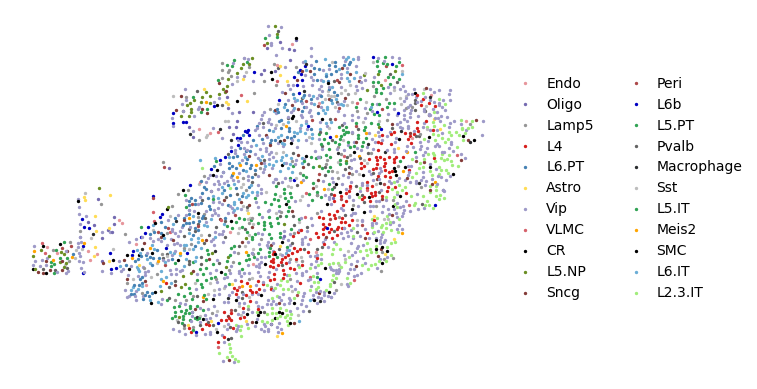

In [35]:
x = ad_st.obs.x.values
y = ad_st.obs.y.values
plt.axis('off')
for x_val, y_val, color_val,g in zip(x, y, color_list,list(max_columns)):
    plt.scatter(x_val, y_val, color=color_val,s=2,label=g)
handles, labels = plt.gca().get_legend_handles_labels()
unique_labels = list(set(labels))
unique_handles = [handles[labels.index(label)] for label in unique_labels]
plt.legend(unique_handles,unique_labels,loc=(1,0.2),fontsize = 10,ncol =2,frameon=False,handlelength=2, handletextpad=0.5)
plt.gca().invert_yaxis()
plt.savefig('./fig/Visp_Mer_all.pdf',bbox_inches='tight',dpi=300)

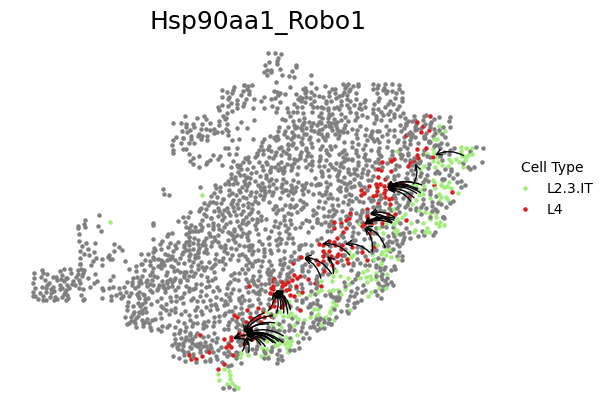

In [34]:
#os.chdir("/mnt/test/a3/DeepSpa/dataset/VISP_MER")
df = pd.read_csv('./ad_st_new.csv',index_col=0)
Sst_value = df.loc['Sst']
Sstr2_value = df.loc['Sstr2']
Nodeall = np.loadtxt('./data/Sst_Sstr2/CCIlist.txt',skiprows=0,dtype=str,delimiter=' ')
nodelabel = Nodeall[:,-1]
nodes = Nodeall[:,1]
nodet = Nodeall[:,2]
cell_type = list(max_columns)
sourcetype = 'L2.3.IT'
targettype = 'L4'
cor_x = list(pd.DataFrame(ad_st.obs).iloc[:, 0])
cor_y = list(pd.DataFrame(ad_st.obs).iloc[:, 1])

score_list = []
index = []
for i in range(len(nodelabel)):
    if nodelabel[i] == '1':
        if cell_type[int(nodes[i])] == sourcetype and cell_type[int(nodet[i])] == targettype:
            score_list.append(np.sqrt(Sst_value[int(nodes[i])]*Sstr2_value[int(nodet[i])]))
sorted_list = sorted(enumerate(score_list), key=lambda x: x[1],reverse=True)[0:50]
sorted_indices = [index for index, _ in sorted_list]
sorted_values = [value for _, value in sorted_list]
Ther = sorted_values[-1]
x_y_1 = []
x_y_2 = []

for i in range(len(nodelabel)):
    if nodelabel[i] == '1':
        if cell_type[int(nodes[i])] == sourcetype and cell_type[int(nodet[i])] == targettype:
            score = np.sqrt(Sst_value[int(nodes[i])] * Sstr2_value[int(nodet[i])])
            if score > Ther:
                x_y_1.append(((cor_x[int(nodes[i])]),((cor_y[int(nodes[i])]))))
                x_y_2.append(((cor_x[int(nodet[i])]),((cor_y[int(nodet[i])]))))

        
x = ad_st.obs.x.values
y = ad_st.obs.y.values
plt.axis('off')
for x_val, y_val, color_val,g in zip(x, y, color_list,list(max_columns)):
    if g == sourcetype or g == targettype:
        plt.scatter(x_val, y_val, color=color_val,s=5,label=g)
    else:
        plt.scatter(x_val, y_val, color='gray',s=5)

handles, labels = plt.gca().get_legend_handles_labels()
unique_labels = list(set(labels))
unique_handles = [handles[labels.index(label)] for label in unique_labels]
plt.legend(unique_handles,unique_labels,loc=(1,0.5),fontsize = 10,ncol = 1,frameon=False,handlelength=2, handletextpad=0.5,title='Cell Type')

#plt.legend(label,loc=(1,0.5),fontsize = 10,ncol = 1,frameon=False,handlelength=2, handletextpad=0.5,title='Cell Type')


for i in range(len(x_y_1)):
    plt.annotate("",
                 xy=x_y_2[i], xycoords='data',
                 xytext=x_y_1[i], textcoords='data',
                 arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=0.3", linewidth=1))
plt.title('Sst_Sstr2', fontsize=18)
plt.gca().invert_yaxis()
plt.savefig('./fig/Sst_Sstr2.pdf',bbox_inches='tight',dpi=300)

In [13]:
import os
df = pd.read_csv('./st_meta.csv',sep = ',',index_col=0)
max_columns = df['celltype'].values
#os.chdir("/mnt/test/a3/DeepSpa/dataset/VISP_MER")
df = pd.read_csv('./ad_st_new.csv',index_col=0)
Sst_value = df.loc['Sst']
Sstr2_value = df.loc['Sstr2']
Nodeall = np.loadtxt('./data/Sst_Sstr2/CCIlist.txt',skiprows=0,dtype=str,delimiter=' ')
nodelabel = Nodeall[:,-1]
nodes = Nodeall[:,1]
nodet = Nodeall[:,2]
#nodescore = Nodeall[:,3]
cell_type = list(max_columns)

unique_cell_type = list(set(cell_type))
#print(unique_cell_type)
#unique_cell_type.remove('Oligo')
unique_cell_type=['L2.3.IT','L4', 'L5.NP', 'CR','L5.IT', 'L5.PT', 'L6.IT','L6b' , 'L6.PT']
data =  np.zeros((len(unique_cell_type),len(unique_cell_type)))
#print(data.shape)

for i in range(data.shape[0]):
    print("cells:",unique_cell_type[i])
    for j in range(data.shape[0]):
        #print("cellt:",unique_cell_type[j])
        sourcetype = unique_cell_type[i]
        targettype = unique_cell_type[j]
        score = []
        for m in range(len(nodelabel)):
            if nodelabel[m] == '1':
                if cell_type[int(nodes[m])] == sourcetype and cell_type[int(nodet[m])] == targettype:
                    score1 = np.sqrt(Sst_value[int(nodes[m])] * Sstr2_value[int(nodet[m])])
                    score.append(score1)
                else:
                    score.append(0)
            else:
                score.append(0)
        #print(score)
        score_mean =  np.mean(np.array(score).astype(np.float64))
        data[i][j] =  score_mean
#data

cells: L2.3.IT
cells: L4
cells: L5.NP
cells: CR
cells: L5.IT
cells: L5.PT
cells: L6.IT
cells: L6b
cells: L6.PT


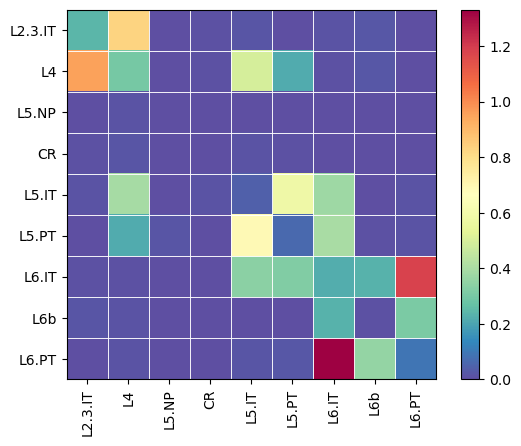

In [14]:
import numpy as np
import matplotlib.pyplot as plt
data_filled = np.nan_to_num(data, nan=0)
rows = np.any(data_filled != 0, axis=1)
cols = np.any(data_filled != 0, axis=0)
result = data_filled[rows][:, cols]
# 创建一个示例数据
#data = np.random.rand(5, 5)

# 创建样本名称列表
sample_names = unique_cell_type

# 绘制热图
plt.imshow(result*100,cmap = 'Spectral_r')

num_rows, num_cols = result.shape
for i in range(num_rows):
    for j in range(num_cols):
        plt.gca().add_patch(plt.Rectangle((j - 0.5, i - 0.5), 1, 1, edgecolor='white', linewidth=0.5, fill=False))



# 设置x轴和y轴刻度
plt.xticks(np.arange(len(sample_names)), sample_names, rotation=90)
plt.yticks(np.arange(len(sample_names)), sample_names)

# 添加颜色栏
plt.colorbar()
plt.savefig(',/fig/Heatmap_Sst_Sstr2.pdf',bbox_inches='tight',dpi=300)
# 显示图形
plt.show()
